https://corporatefinanceinstitute.com/resources/knowledge/trading-investing/historical-volatility-hv/

In [4]:
import pandas as pd

df = df = pd.read_excel("Complete-dataset-FINAL.xlsx")
df['Year'] = pd.to_datetime(df["Year"], format='%Y')

cap = df.loc[df['Source (CAP/EurA1c)'] == 'CAP']
eur = df.loc[df['Source (CAP/EurA1c)'] == 'EURA1c']

In [55]:
cap_cv = cap[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()
eur_cv = eur[["Year", "Method name", "CV"]].groupby(["Method name", "Year"]).mean()

In [341]:
# CAP
df = eur_cv.copy()

methods = eur_cv.index.get_level_values(0).unique()

volatility = pd.DataFrame(columns=["Method", "Volatility", "Data points amount"])

for method in methods:
    if len(df.loc[method]) < 5:
        continue
    cvs = df.loc[method]
    variance = cvs.std(ddof=0)[0]
    volatility = pd.concat([volatility, pd.DataFrame({"Method": [method], "Volatility": [variance]})])

volatility.sort_values(by=["Volatility"], inplace=True)
volatility.reset_index(drop=True, inplace=True)
volatility.set_index("Method", inplace=True)

for method in methods:
    volatility.loc[method, "Data points amount"] = len(df.loc[method])

classes = []
count = 0
while count < len(volatility):
    classes.append(int(count/5) + 1)
    count += 1
volatility["Class"] = classes
volatility.dropna(inplace=True)
volatility["Volatility"] = volatility["Volatility"].astype(float)
volatility["Data points amount"] = volatility["Data points amount"].astype(int)

volatility.head(20)

,Volatility,Data points amount,Class
Method,,,
Tosoh G8 Auto HPLC,0.257196,5,1
Bio-Rad D-10,0.279106,5,1
Alere Afinion,0.374700,5,1
Bio-Rad D-100,0.465994,5,1
Beckman Coulter AU Systems,0.475237,5,1
Arkray Adams HA-8180 series,0.488365,5,2
Siemens Dimension series,0.509313,5,2
Siemens DCA 2000/Vantage,0.568639,5,2
Arkray Adams HA-8160 series,0.605929,5,2


<AxesSubplot:>

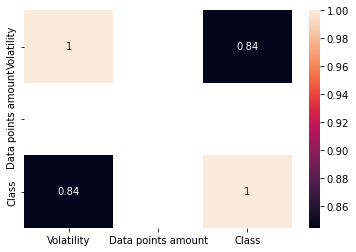

In [342]:
import seaborn as sns
sns.heatmap(volatility.corr(), annot=True)

1 2
0 0
0 1


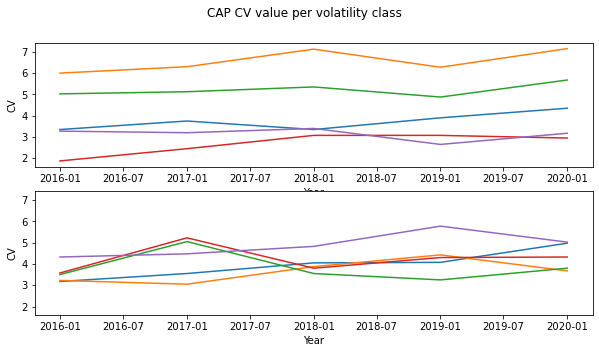

In [346]:
import numpy as np
from math import ceil, floor
df["Class"] = np.nan

for method in volatility.index:
    df.loc[method, "Class"] = volatility.loc[method, "Class"]

class_amount = int(df["Class"].max())

rows = ceil(class_amount / 5)
columns = ceil(class_amount / 2)

print(rows, columns)

fig, axes = plt.subplots(columns, rows, figsize=(10, 5), sharey=True, squeeze=False)

fig.suptitle("CAP CV value per volatility class")

for i in range(1, class_amount):
    selection = df.loc[df["Class"] == i]
    x = (i - 1) % rows
    y = floor((i - 1) / rows)
    print(x, y)
    sns.lineplot(ax=axes[y, x], data=selection, x="Year", y="CV", hue="Method name", legend=False)

plt.show()
